# Preparing the main-table
We will subsequently in each section fill more columns of that table.

In [18]:
import pandas as pd
main_table = pd.DataFrame(columns=["date","flow","stock","s2f","price","marketcap","lns2f","lnmarketcap"])
main_table.set_index("date",inplace=True)
print("The main_table is where we'll do the main calculation. The structure looks like this:")
main_table

The main_table is where we'll do the main calculation. The structure looks like this:


,flow,stock,s2f,price,marketcap,lns2f,lnmarketcap
date,,,,,,,


# Fill the flow-column

In [19]:
from pathlib import Path
import pandas as pd
import pandas_datareader.data as web
monthly_flow = pd.read_csv(Path("./data/flow_monthly.csv"), index_col="date",parse_dates=["date"])
main_table['flow'] = monthly_flow["flow"]
main_table

,flow,stock,s2f,price,marketcap,lns2f,lnmarketcap
date,,,,,,,
2009-01-31,127100.0,NaN,NaN,NaN,NaN,NaN,NaN
2009-02-28,169000.0,NaN,NaN,NaN,NaN,NaN,NaN
2009-03-31,173300.0,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-30,172100.0,NaN,NaN,NaN,NaN,NaN,NaN
2009-05-31,169150.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2020-01-31,59212.5,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-29,51925.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-31,53187.5,NaN,NaN,NaN,NaN,NaN,NaN


PlanB assumed that the first roughly 1.000.000 Coins are lost (exactly 1018700.0 until 2009-07-31)

So let's simply fill the stock-column for these rows with 0

In [20]:
import datetime

lost_coins_treshold = datetime.datetime(2009, 7, 31)
main_table.loc[main_table.index <= lost_coins_treshold,'flow'] = 0
# For more example on selecting subsets of a dataframe:
# https://brohrer.github.io/dataframe_indexing.html
main_table

,flow,stock,s2f,price,marketcap,lns2f,lnmarketcap
date,,,,,,,
2009-01-31,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2009-02-28,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2009-03-31,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-30,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2009-05-31,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2020-01-31,59212.5,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-29,51925.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-31,53187.5,NaN,NaN,NaN,NaN,NaN,NaN


# cumulate flow to stock and s2f

In [21]:
main_table['stock'] = main_table['flow'].cumsum()
main_table['s2f'] = main_table['stock'] / (main_table['flow'] *12)
# We have to avoid negative values, so let's abs
#monthly_flow['s2f'] = np.absolute(monthly_flow['s2f'])
# Also we have 2009-07-31 which has a s2f=0 needs a special treatment to not get a divide by zero
main_table.loc['2009-07-31','s2f'] = 0.000001
main_table

,flow,stock,s2f,price,marketcap,lns2f,lnmarketcap
date,,,,,,,
2009-01-31,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2009-02-28,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2009-03-31,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2009-04-30,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2009-05-31,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2020-01-31,59212.5,15923725.0,22.410422,NaN,NaN,NaN,NaN
2020-02-29,51925.0,15975650.0,25.638983,NaN,NaN,NaN,NaN
2020-03-31,53187.5,16028837.5,25.113729,NaN,NaN,NaN,NaN


# Load Pricedata into main_table

In [22]:
# which procedata should we take? We have three options:
# The original Data from PlanB
monthly_prices_planb = pd.read_csv(Path("./data/planb_s2f_pricedata.csv"),index_col="date",parse_dates=["date"])
monthly_prices_planb = monthly_prices_planb.price.resample("M").sum().to_frame()
# Prices from Bitstamp via bitcoincharts
monthly_prices_bitstmp = pd.read_csv(Path("./data/bitstampUSD_monthly.csv"), index_col="timestamp",parse_dates=["timestamp"])
# Prices from coinmetrics
monthly_prices_coinmtrc = pd.read_csv(Path("./data/coinmetric_btc_monthly.csv"), index_col="date",parse_dates=["date"])

# choose here:
#choice = "Bitstamp"
#choice = "PlanB"
choice = "coinmetric"
if choice == "PlanB":
    main_table['price'] = monthly_prices_planb
elif choice == "coinmetric":
    last_unknown_price_date = datetime.datetime(2010, 7, 31)
    main_table['price'] = monthly_prices_coinmtrc["price"]
else:
    main_table['price'] = monthly_prices_bitstmp["price"]
    last_unknown_price_date = datetime.datetime(2011, 9, 30)

# Prices between 2009-01-31 and last_unknown_price_date can be filled up with PlanB's interpolated prices
# Should we do that?
interpolate = True
if interpolate and choice != "PlanB":
    main_table["price"] = pd.concat([monthly_prices_planb.loc[monthly_prices_planb.index <= last_unknown_price_date,"price"],main_table.loc[main_table.index > last_unknown_price_date,'price']])


main_table.head(50)

,flow,stock,s2f,price,marketcap,lns2f,lnmarketcap
date,,,,,,,
2009-01-31,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2009-02-28,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2009-03-31,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2009-04-30,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2009-05-31,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2009-06-30,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2009-07-31,0.0,0.0,0.000001,NaN,NaN,NaN,NaN
2009-08-31,78200.0,78200.0,0.083333,NaN,NaN,NaN,NaN
2009-09-30,107950.0,186150.0,0.143701,NaN,NaN,NaN,NaN


# Calculate marketcap and ln of markectcap and s2f

In [23]:
import numpy as np
main_table['marketcap'] = main_table['price'] * main_table['stock'] 
main_table['lns2f'] = np.log(main_table['s2f'])
main_table['lnmarketcap'] = np.log(main_table['marketcap'])
main_table

,flow,stock,s2f,price,marketcap,lns2f,lnmarketcap
date,,,,,,,
2009-01-31,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2009-02-28,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2009-03-31,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2009-04-30,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2009-05-31,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2020-01-31,59212.5,15923725.0,22.410422,8365.735932,1.332137e+11,3.109526,25.615220
2020-02-29,51925.0,15975650.0,25.638983,9646.192816,1.541042e+11,3.244114,25.760895
2020-03-31,53187.5,16028837.5,25.113729,6885.037265,1.103591e+11,3.223415,25.427006


# Data Cleaning
This is necessary as the price-data-sources and the blockdata do usually NOT cover the exact same dates. So let's simply drop the rows which don't have filled data.

In [28]:
# If the regression-function is failing somewhere, you might have other 
# weird values in your data. Two of them might be "np.inf" and "-np.inf"
# Those get created by Division by zero
# Just to check that assumption, you can uncomment the following line
main_table.replace([np.inf, -np.inf], np.nan, inplace=True)

# This function simply drops all rows which has a "NaN" (not a number)
# in any of its columns
main_table.dropna(inplace=True)
main_table

,flow,stock,s2f,price,marketcap,lns2f,lnmarketcap
date,,,,,,,
2009-10-31,106300.0,292450.0,0.229265,0.001000,2.924500e+02,-1.472878,5.678294
2009-11-30,110850.0,403300.0,0.303187,0.002000,8.066000e+02,-1.193404,6.692828
2009-12-31,202400.0,605700.0,0.249382,0.002000,1.211400e+03,-1.388768,7.099532
2010-01-31,250200.0,855900.0,0.285072,0.002000,1.711800e+03,-1.255014,7.445301
2010-02-28,280150.0,1136050.0,0.337929,0.002000,2.272100e+03,-1.084919,7.728460
...,...,...,...,...,...,...,...
2020-01-31,59212.5,15923725.0,22.410422,8365.735932,1.332137e+11,3.109526,25.615220
2020-02-29,51925.0,15975650.0,25.638983,9646.192816,1.541042e+11,3.244114,25.760895
2020-03-31,53187.5,16028837.5,25.113729,6885.037265,1.103591e+11,3.223415,25.427006


# Finally the Regression-analysis
See https://blog.datarobot.com/ordinary-least-squares-in-python on much more details on this.

Also very helpful is a two part blog-serie about regression-analysis in Python also covering matplotlib
https://medium.com/@dhwajraj/python-regression-analysis-part-1-setups-f592ff39da58

In [29]:
import statsmodels.api as sm
y = main_table.lnmarketcap  # response
X = main_table.lns2f        # predictor
X = sm.add_constant(X)      # Adds a constant term to the predictor
X

,const,lns2f
date,,
2009-10-31,1.0,-1.472878
2009-11-30,1.0,-1.193404
2009-12-31,1.0,-1.388768
2010-01-31,1.0,-1.255014
2010-02-28,1.0,-1.084919
...,...,...
2020-01-31,1.0,3.109526
2020-02-29,1.0,3.244114
2020-03-31,1.0,3.223415


In [30]:
est=sm.OLS(y, X)
est = est.fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            lnmarketcap   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     1321.
Date:                Sun, 10 May 2020   Prob (F-statistic):           2.64e-61
Time:                        17:00:51   Log-Likelihood:                -182.28
No. Observations:                 107   AIC:                             368.6
Df Residuals:                     105   BIC:                             373.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.4589      0.218     61.728      0.000      13.027      13.891
lns2f          3.6630      0.101     36.351      0.000       3.463       3.863
==============================================================================
Omnibus:                       21.144   Durbin-Watson:                   0.518
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.674
Skew:                          -0.794   Prob(JB):                     1.47e-09
Kurtosis:                       5.570   Cond. No.                         4.17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
print(est.params)
import math
# Gleichung erklären!
main_table['marketcapmodelprice'] = math.exp(est.params.const) * main_table['s2f'].pow(est.params.lns2f)
main_table['modelprice'] = main_table['marketcapmodelprice'] / main_table['stock']
main_table.tail()


const    13.458946
lns2f     3.663041
dtype: float64


,flow,stock,s2f,price,marketcap,lns2f,lnmarketcap,marketcapmodelprice,modelprice
date,,,,,,,,,
2020-01-31,59212.5,15923725.0,22.410422,8365.735932,1.332137e+11,3.109526,25.615220,6.192975e+10,3.889150e+03
2020-02-29,51925.0,15975650.0,25.638983,9646.192816,1.541042e+11,3.244114,25.760895,1.013927e+11,6.346705e+03
2020-03-31,53187.5,16028837.5,25.113729,6885.037265,1.103591e+11,3.223415,25.427006,9.398913e+10,5.863752e+03
2020-04-30,56412.5,16085250.0,23.761356,7224.347704,1.162054e+11,3.168061,25.478625,7.673936e+10,4.770791e+03
2020-05-31,9662.5,16094912.5,138.809077,9254.963920,1.489578e+11,4.933099,25.726929,4.930712e+13,3.063522e+06


In [32]:
main_table["s2f_365"] = main_table.s2f.rolling(12, win_type ='triang').mean()
main_table


,flow,stock,s2f,price,marketcap,lns2f,lnmarketcap,marketcapmodelprice,modelprice,s2f_365
date,,,,,,,,,,
2009-10-31,106300.0,292450.0,0.229265,0.001000,2.924500e+02,-1.472878,5.678294,3.177130e+03,1.086384e-02,NaN
2009-11-30,110850.0,403300.0,0.303187,0.002000,8.066000e+02,-1.193404,6.692828,8.843690e+03,2.192832e-02,NaN
2009-12-31,202400.0,605700.0,0.249382,0.002000,1.211400e+03,-1.388768,7.099532,4.323556e+03,7.138115e-03,NaN
2010-01-31,250200.0,855900.0,0.285072,0.002000,1.711800e+03,-1.255014,7.445301,7.057034e+03,8.245162e-03,NaN
2010-02-28,280150.0,1136050.0,0.337929,0.002000,2.272100e+03,-1.084919,7.728460,1.315876e+04,1.158291e-02,NaN
...,...,...,...,...,...,...,...,...,...,...
2020-01-31,59212.5,15923725.0,22.410422,8365.735932,1.332137e+11,3.109526,25.615220,6.192975e+10,3.889150e+03,27.445502
2020-02-29,51925.0,15975650.0,25.638983,9646.192816,1.541042e+11,3.244114,25.760895,1.013927e+11,6.346705e+03,28.922659
2020-03-31,53187.5,16028837.5,25.113729,6885.037265,1.103591e+11,3.223415,25.427006,9.398913e+10,5.863752e+03,30.102584


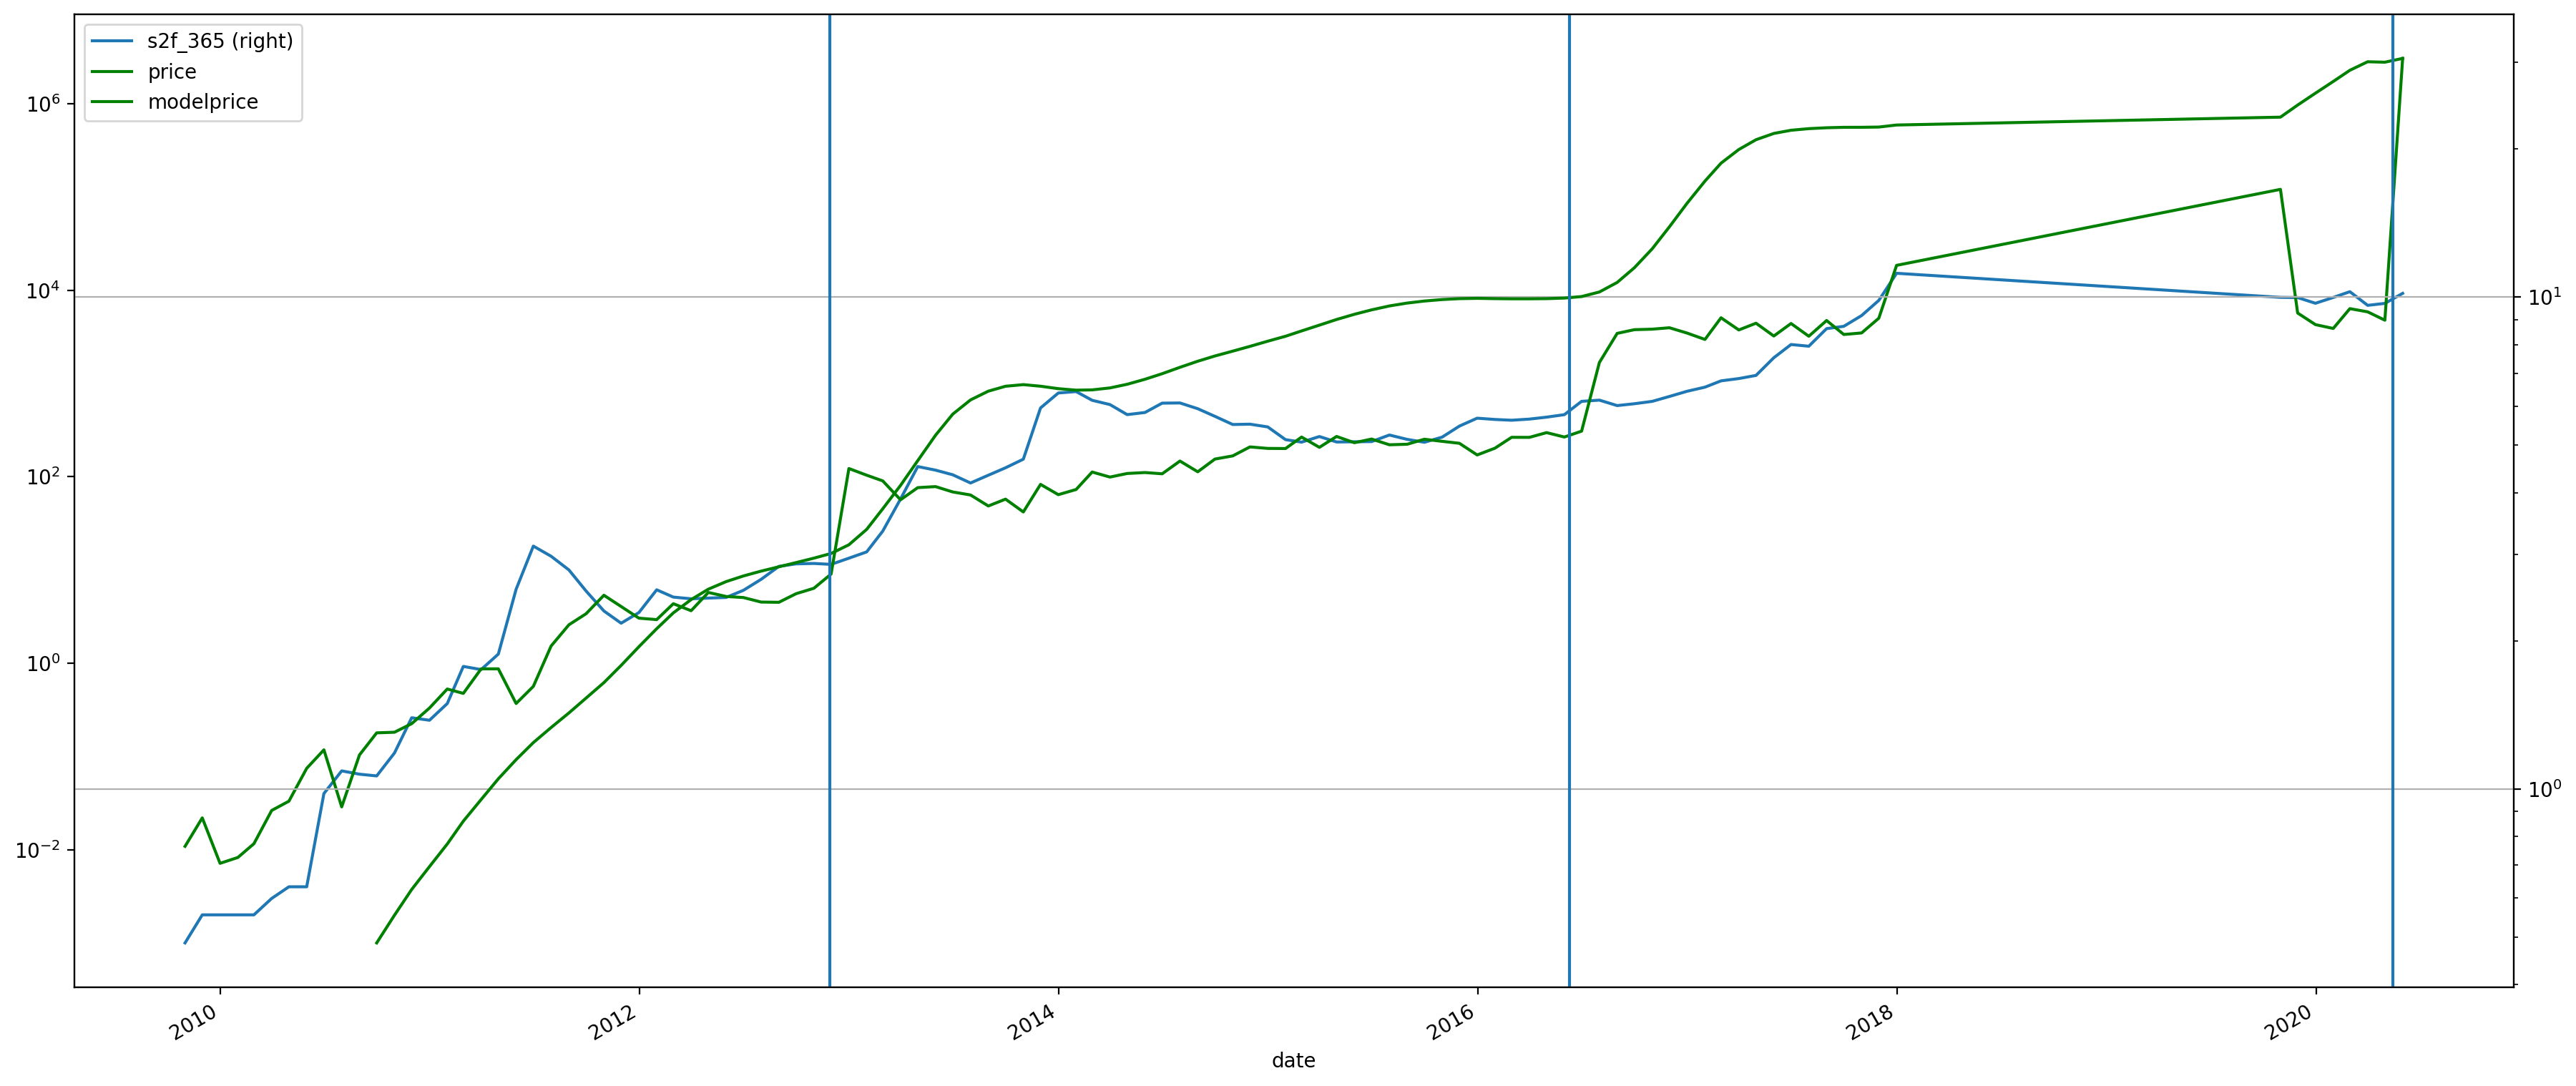

In [35]:
import matplotlib
import matplotlib.pyplot as plt
# Documentation on how to use matplotlib with pandas:
# https://pandas.pydata.org/pandas-docs/version/0.13/visualization.html#selective-plotting-on-secondary-y-axis
plt.figure(figsize=(22,10), dpi=200)


ax = plt.plot(secondary_y=['price', 'modelprice'])


main_table['s2f_365'].plot(secondary_y=True,style='g',logy=True, legend="s2f (365)")
main_table['price'].plot(logy=True, legend="price")
main_table['modelprice'].plot(style='g',logy=True, legend="modelprice")

plt.grid(b=True)

# Show halvings
plt.axvline(datetime.date(2012,11,28), 0, 1, label='1nd halving')
plt.axvline(datetime.date(2016, 6, 9), 0, 1, label='2nd halving')
plt.axvline(datetime.date(2020, 5, 14), 0, 1, label='2nd halving')

plt.show()

# Predict some Prices

In [144]:
# this creates a new index out of future dates based on the last date in _main_table
new_dates_series = pd.date_range(start=main_table.index[-1], periods=12, freq='M')
# now we create a table similiar to main_table but only with the new dates
# trick founjd at:
# https://skipperkongen.dk/2018/11/26/how-to-fill-missing-dates-in-pandas/
new_dates = main_table.reindex(new_dates_series).fillna(0.0).rename_axis('date')
# Let's fill the row column. 10 minutes blocks now creating 6.25 btc
new_dates["flow"] = 30 * 24 * 6 * 6.25
# concatinate both tables (ommitting the last month)
# We use a copy of main_table to be able to compare easily between the two if in doubt
main_table2 = pd.concat([main_table.iloc[:-1],new_dates])
# All the known calculations again
# For the prediction, we only need s2f
main_table2['stock'] = main_table2['flow'].cumsum()
main_table2['s2f'] = main_table2['stock'] / (main_table2['flow'] *12)
main_table2['marketcapmodelprice'] = math.exp(est.params.const) * main_table2['s2f'].pow(est.params.lns2f)
main_table2['modelprice'] = main_table2['marketcapmodelprice'] / main_table2['stock']
main_table2['modelprice'].tail(15)



date
2020-01-31     4809.452382
2020-02-29     7838.680808
2020-03-31     7239.514280
2020-04-30    86778.507650
2020-05-31    87145.326373
2020-06-30    87513.110609
2020-07-31    87881.861365
2020-08-31    88251.579647
2020-09-30    88622.266460
2020-10-31    88993.922808
2020-11-30    89366.549697
2020-12-31    89740.148128
2021-01-31    90114.719106
2021-02-28    90490.263633
2021-03-31    90866.782711
Name: modelprice, dtype: float64